In [946]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as tsaplots
import warnings
warnings.filterwarnings("ignore")

In [947]:
data = pd.read_csv('data/SP500modeldataset.csv')

In [948]:
data.info()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(data['Date'])
data= data.drop('Date',axis=1)
data= data.dropna()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2407 entries, 0 to 2406
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     2382 non-null   object 
 1   previous_open                            2377 non-null   float64
 2   previous_high                            2377 non-null   float64
 3   previous_low                             2377 non-null   float64
 4   previous_close                           2377 non-null   float64
 5   previous_volume                          2377 non-null   float64
 6   close_price                              2376 non-null   float64
 7   jobless_claims                           2377 non-null   float64
 8   previous_week_2_year_constant_maturity   2379 non-null   float64
 9   previous_week_7_year_constant_maturity   2379 non-null   float64
 10  previous_week_30_year_constant_maturity  2379 no

,previous_open,previous_high,previous_low,previous_close,previous_volume,close_price,jobless_claims,previous_week_2_year_constant_maturity,previous_week_7_year_constant_maturity,previous_week_30_year_constant_maturity,...,40_week_ma_prev_week,52_week_ma_prev_week,100_week_ma_prev_week,4_week_rolling_std dev_prev_week,13_week_rolling_std_dev_prev_week,26_week_rolling_std_dev_prev_week,40_week_rolling_std_dev_prev_week,52_week_rolling_std_dev_prev_week,vix_close_price_prev_week_,nasdaq_close_price_prev_week
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-04,4195.08,4203.04,4057.66,4057.66,9.464275e+09,3924.26,172835.0,3.37,3.14,3.21,...,4283.59800,4339.899423,4160.0021,3.046467439,3.702767244,3.447551329,3.082388533,2.781270506,25.56,12141.71
1997-06-29,893.27,901.77,886.19,898.70,1.466156e+09,887.30,298299.0,6.02,6.37,6.65,...,771.65300,745.385577,684.0253,1.785032889,2.53400204,2.079451372,1.932825049,1.950601216,20.20,1447.10
2018-10-07,2921.83,2931.15,2903.28,2913.98,9.188589e+09,2885.57,193936.0,2.81,3.01,3.19,...,2762.53025,2726.235962,2551.5808,1.05859814,0.774843644,0.999543927,2.02493828,1.793184356,12.12,8046.35
2011-06-12,1331.10,1345.20,1297.90,1300.16,9.002517e+09,1270.98,400608.0,0.42,2.28,4.22,...,1258.73475,1218.117500,1154.4635,1.051672355,1.558805475,1.399590894,1.533957391,2.010901881,17.95,2732.78
2009-02-15,823.09,870.75,812.87,868.60,1.727120e+10,826.84,619951.0,0.99,2.40,3.70,...,1108.00650,1163.183269,1312.1950,4.125099978,5.613752531,6.222330113,5.154718597,4.699524524,43.37,1591.71
2006-09-10,1295.09,1312.03,1293.97,1311.01,5.424661e+09,1298.92,240231.0,4.77,4.69,4.87,...,1279.02200,1265.696538,1228.0930,1.742894029,1.776249459,1.53676595,1.46104194,1.46809023,11.96,2193.16
2010-10-31,1176.83,1189.43,1159.71,1183.08,1.271189e+10,1183.26,421097.0,0.35,1.88,3.94,...,1118.62450,1114.697500,1017.7726,0.774572323,1.804019686,2.911883457,2.579582667,2.445520611,18.78,2479.39
2007-01-21,1409.26,1431.23,1403.97,1430.73,7.839294e+09,1430.50,367583.0,4.88,4.76,4.86,...,1325.94575,1316.537500,1267.1685,1.178446813,0.910159184,1.132851789,1.35896735,1.323650626,10.15,2502.82
2020-11-15,3296.20,3529.05,3279.74,3509.44,1.248223e+10,3585.15,708717.0,0.16,0.59,1.60,...,3127.03100,3145.764038,3006.4561,5.332353598,3.224228644,3.003405193,4.968710546,4.377212481,24.86,11895.23


Below I created a column for log returns, log returns are stationary- making then more easily digestible for time series models.

In [952]:
data['log_returns'] = np.log(data['close_price']).diff().dropna()
data= data.dropna()

In [953]:
data['4_week_rolling_std dev_prev_week']=data['4_week_rolling_std dev_prev_week'].astype(float)
data['13_week_rolling_std_dev_prev_week']=data['13_week_rolling_std_dev_prev_week'].astype(float)
data['26_week_rolling_std_dev_prev_week']=data['26_week_rolling_std_dev_prev_week'].astype(float)
data['40_week_rolling_std_dev_prev_week']=data['40_week_rolling_std_dev_prev_week'].astype(float)
data['52_week_rolling_std_dev_prev_week']=data['52_week_rolling_std_dev_prev_week'].astype(float)
data.info()
data2 = data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1851 entries, 1990-01-21 to 2025-07-06
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   previous_open                            1851 non-null   float64
 1   previous_high                            1851 non-null   float64
 2   previous_low                             1851 non-null   float64
 3   previous_close                           1851 non-null   float64
 4   previous_volume                          1851 non-null   float64
 5   close_price                              1851 non-null   float64
 6   jobless_claims                           1851 non-null   float64
 7   previous_week_2_year_constant_maturity   1851 non-null   float64
 8   previous_week_7_year_constant_maturity   1851 non-null   float64
 9   previous_week_30_year_constant_maturity  1851 non-null   float64
 10  4_week_ma_prev_week           

Text(0, 0.5, 'Weekly Closing Price ($)')

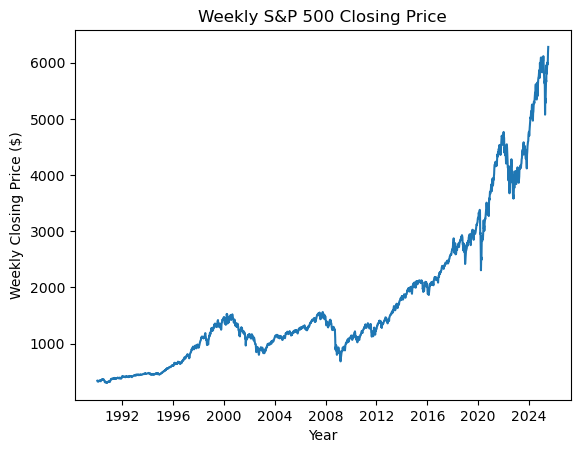

In [954]:
#This plot shows the weekly closing price of the S&P500 since 1982
plt.plot(data['close_price'])
plt.title('Weekly S&P 500 Closing Price')
plt.xlabel('Year')
plt.ylabel('Weekly Closing Price ($)')

Text(0, 0.5, 'Log Returns')

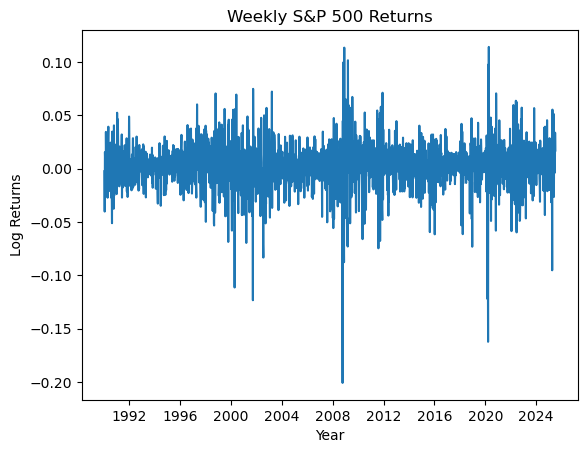

In [955]:
#This plot shows the weekly returns of the S&P500 in %
plt.plot(data['log_returns'])
plt.title('Weekly S&P 500 Returns')
plt.xlabel('Year')
plt.ylabel('Log Returns')

Now i'll start preparing the data to run a simple linear regression on this data. I don't expect this model to be accurate at all, but it will give us an idea of how nuanced financial data is and how crucial the sequential aspect is of it.

In [956]:
X=data.drop(['close_price','log_returns'],axis=1)
y=data['close_price']

Below I have began preparing training and test sets to perform cross validation on the linear regression

In [989]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [990]:
numerical=['previous_open','previous_high','previous_low','previous_close','previous_volume','52_week_ma_prev_week','40_week_ma_prev_week','26_week_ma_prev_week','13_week_ma_prev_week','8_week_ma_prev_week','4_week_ma_prev_week','100_week_ma_prev_week','previous_week_30_year_constant_maturity','previous_week_7_year_constant_maturity','previous_week_2_year_constant_maturity','jobless_claims','4_week_rolling_std dev_prev_week','13_week_rolling_std_dev_prev_week','26_week_rolling_std_dev_prev_week','40_week_rolling_std_dev_prev_week','52_week_rolling_std_dev_prev_week','vix_close_price_prev_week_','nasdaq_close_price_prev_week']

In [991]:
polytransformer = Pipeline([         
                                    ('imputer',SimpleImputer(strategy='mean')),
                                    ('poly',PolynomialFeatures(degree = 3,include_bias=False)),
                                    ('scale',StandardScaler())
                                ])
transformer = [('polynomialtransformations',polytransformer,numerical)]
transform = ColumnTransformer(transformers = transformer,remainder='passthrough')

In [992]:
#The below code replaces all outliers with NAN Values
import pandas as pd
import numpy as np
def replace_outliers_multi_column(df, columns):
  df_copy = df.copy()
  for column in columns:
    # Calculate Q1, Q3, and IQR for the current column
    q1 = df_copy[column].quantile(0.25)
    q3 = df_copy[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identify and replace outliers
    df_copy.loc[
        (df_copy[column] < lower_bound) | (df_copy[column] > upper_bound),
        column
    ] = np.nan
  return df_copy


In [993]:
#This replaces outliers with nan values

columns_to_clean = ['52_week_ma_prev_week','40_week_ma_prev_week','26_week_ma_prev_week','13_week_ma_prev_week','8_week_ma_prev_week','4_week_ma_prev_week','100_week_ma_prev_week','previous_week_30_year_constant_maturity','previous_week_7_year_constant_maturity','previous_week_2_year_constant_maturity','jobless_claims','100_week_ma_prev_week','4_week_rolling_std dev_prev_week','13_week_rolling_std_dev_prev_week','26_week_rolling_std_dev_prev_week','40_week_rolling_std_dev_prev_week','52_week_rolling_std_dev_prev_week']
clean_training = replace_outliers_multi_column(X_train, columns_to_clean)
X_train = clean_training

In [994]:
initialpipe = Pipeline([
    ('transform',transform),
    ('reg',LinearRegression())
])


In [995]:
baselinemodel = initialpipe.fit(X_train,y_train)

In [996]:
preds = baselinemodel.predict(X_test)
baselineerror = mean_squared_error(preds,y_test)

In [998]:
# BELOW IS THE RMSE OF OUR INITIAL FUNCTION 
print(f"The baseline RMSE is: {np.sqrt(baselineerror)}")

The baseline RMSE is: 185639.48379044957


np.float64(0.001575517037741827)

This standard linear regression gave us an RMSE of over 18000, which is nearly 3 times the price of the current S&P 500, esentially that model is useless when it comes to predicting anything about the S&P 500 and we would be better off taking guesses ourselves than using this model. This is because the linear regression is not to handle sequential data like this. When you think about how quickly financial changes can happen like during COVID and in 2008, it makes sense that the models predictions were really far off when using just a standard linear regression.

Now that we have seen how poorly a standard linear regression performs, I will build a true baseline model, called a Random Walk, that will actually give us some information to base our proceeding models off of. 

First I'll need to make the data stationary so that it is suitable for ARIMA:

In [1022]:
diffdata= data.replace([np.inf, -np.inf], np.nan)
diffdata = diffdata.fillna(method='bfill')
diffdata=diffdata.diff()
diffdata=diffdata.dropna()

In [1023]:
diffdata.info()
X1=diffdata.drop(['log_returns'],axis=1)
y1=diffdata['log_returns']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1850 entries, 1990-01-28 to 2025-07-06
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   previous_open                            1850 non-null   float64
 1   previous_high                            1850 non-null   float64
 2   previous_low                             1850 non-null   float64
 3   previous_close                           1850 non-null   float64
 4   previous_volume                          1850 non-null   float64
 5   close_price                              1850 non-null   float64
 6   jobless_claims                           1850 non-null   float64
 7   previous_week_2_year_constant_maturity   1850 non-null   float64
 8   previous_week_7_year_constant_maturity   1850 non-null   float64
 9   previous_week_30_year_constant_maturity  1850 non-null   float64
 10  4_week_ma_prev_week           

In [1053]:
X1_train,X1_test,y1_train, y1_test = train_test_split(X1,y1,test_size=0.20,shuffle=False)

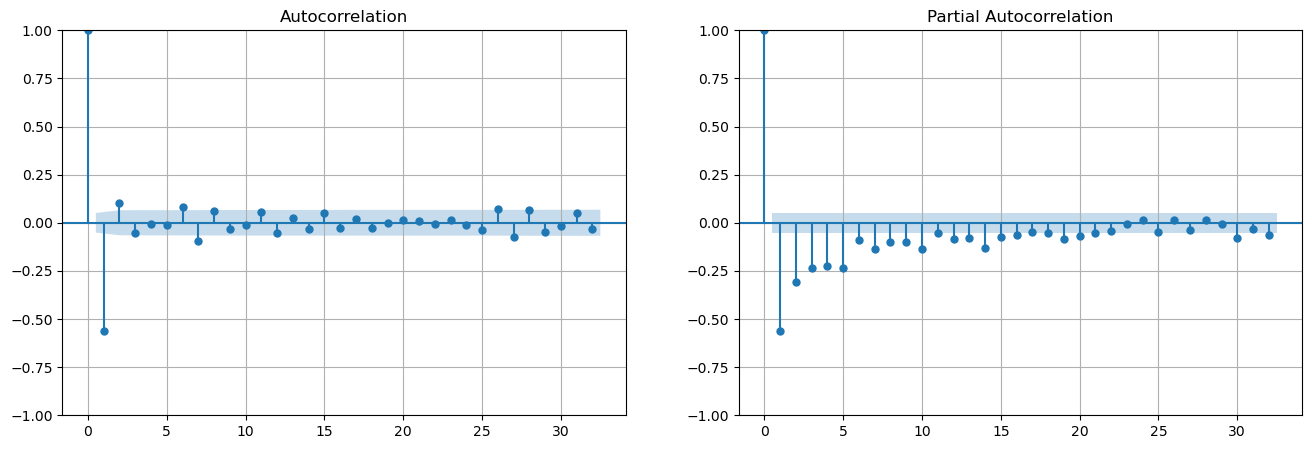

In [1054]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y1_train, ax = ax[0]);
ax[0].grid()
plot_pacf(y1_train, ax = ax[1], method = 'ywm');
ax[1].grid()

In [1069]:
randomwalk = SARIMAX(y1_train, order=(0, 1, 0), trend='c').fit()

In [1071]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
randomwalk_preds = randomwalk.predict(start=start_index, end=end_index,dynamic=True)
random_mse_test = mean_squared_error(randomwalk_preds, y1_test)
### ANSWER CHECK
print(randomwalk_preds)
print(random_mse_test)

2018-06-10    0.001822
2018-06-17    0.001848
2018-06-24    0.001875
2018-07-01    0.001902
2018-07-08    0.001928
                ...   
2025-06-08    0.011561
2025-06-15    0.011588
2025-06-22    0.011615
2025-06-29    0.011642
2025-07-06    0.011668
Freq: W-SUN, Name: predicted_mean, Length: 370, dtype: float64
0.00158104481443746


In [1055]:
arma = ARIMA(y1_train, order = (1, 0, 1)).fit()

In [1063]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
preds = arma.predict(start=start_index, end=end_index,dynamic=True)
mse_test = mean_squared_error(preds, y1_test)
### ANSWER CHECK
print(preds)
print(mse_test)

2018-06-10   -0.003250
2018-06-17    0.000224
2018-06-24   -0.000018
2018-07-01   -0.000001
2018-07-08   -0.000002
                ...   
2025-06-08   -0.000002
2025-06-15   -0.000002
2025-06-22   -0.000002
2025-06-29   -0.000002
2025-07-06   -0.000002
Freq: W-SUN, Name: predicted_mean, Length: 370, dtype: float64
0.0015285830361406068


In [1057]:
preds.tail(300)

2019-10-13   -0.000002
2019-10-20   -0.000002
2019-10-27   -0.000002
2019-11-03   -0.000002
2019-11-10   -0.000002
                ...   
2025-06-08   -0.000002
2025-06-15   -0.000002
2025-06-22   -0.000002
2025-06-29   -0.000002
2025-07-06   -0.000002
Freq: W-SUN, Name: predicted_mean, Length: 300, dtype: float64

I Decided against replacing any outliers because financial data is known to have spikes for certain economic reasons

In [1058]:
sarimax = SARIMAX(y1_train,exog=X1_train,  order=(1, 0, 1), seasonal_order=(0, 0, 0, 0)).fit()

In [1059]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 1480
Model:               SARIMAX(1, 0, 1)   Log Likelihood                4769.594
Date:                Mon, 11 Aug 2025   AIC                          -9485.188
Time:                        18:51:27   BIC                          -9342.093
Sample:                    01-28-1990   HQIC                         -9431.844
                         - 06-03-2018                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
previous_open                            2.923e-05   1.69e-06     17.310      0.000    2.59e-05    3.25e-05
previous_high                              -0.0001   1.42e-06    -71.268      0.000      -0.000   -9.85e-05
previous_low                             3.685e-05   1.09e-06     33.653      0.000    3.47e-05     3.9e-05
previous_close                             -0.0007   9.87e-07   -693.405      0.000      -0.001      -0.001
previous_volume                            3.7e-14   1.62e-13      0.229      0.819    -2.8e-13    3.54e-13
close_price                                 0.0008   3.93e-06    192.050      0.000       0.001       0.001
jobless_claims                           -1.52e-08   5.07e-09     -2.997      0.003   -2.51e-08   -5.26e-09
previous_week_2_year_constant_maturity      0.0065   2.46e-09   2.63e+06      0.000       0.006       0.006
previous_week_7_year_constant_maturity      0.0003   1.83e-09   1.55e+05      0.000       0.000       0.000
previous_week_30_year_constant_maturity     0.0035   1.73e-09   2.01e+06      0.000       0.003       0.003
4_week_ma_prev_week                     -6.845e-05   1.22e-06    -56.259      0.000   -7.08e-05   -6.61e-05
8_week_ma_prev_week                     -1.186e-05   1.02e-06    -11.632      0.000   -1.39e-05   -9.86e-06
13_week_ma_prev_week                    -3.084e-05   6.96e-07    -44.302      0.000   -3.22e-05   -2.95e-05
26_week_ma_prev_week                        0.0001   5.99e-07    196.917      0.000       0.000       0.000
40_week_ma_prev_week                    -6.073e-05   4.39e-07   -138.181      0.000   -6.16e-05   -5.99e-05
52_week_ma_prev_week                    -6.753e-05    3.7e-07   -182.388      0.000   -6.83e-05   -6.68e-05
100_week_ma_prev_week                   -2.797e-05   2.75e-07   -101.583      0.000   -2.85e-05   -2.74e-05
4_week_rolling_std dev_prev_week           -0.0027   2.17e-08  -1.25e+05      0.000      -0.003      -0.003
13_week_rolling_std_dev_prev_week       -7.321e-06   1.07e-08   -682.934      0.000   -7.34e-06    -7.3e-06
26_week_rolling_std_dev_prev_week           0.0074   5.29e-09    1.4e+06      0.000       0.007       0.007
40_week_rolling_std_dev_prev_week           0.0011   3.33e-09   3.18e+05      0.000       0.001       0.001
52_week_rolling_std_dev_prev_week          -0.0008   3.01e-09  -2.53e+05      0.000      -0.001      -0.001
vix_close_price_prev_week_                  0.0015   1.11e-07   1.37e+04      0.000       0.002       0.002
nasdaq_close_price_prev_week             3.281e-05   1.43e-06     22.879      0.000       3e-05    3.56e-05
ar.L1                                      -0.0342   3.18e-10  -1.08e+08      0.000      -0.034      -0.034
ma.L1                                      -0.5894   4.45e-10  -1.32e+09      0.000      -0.589      -0.589
sigma2                                   9.436e-05   1.77e-06     53.357      0.000    9.09e-05    9.78e-05
=

In [1052]:
sarimax_start_index = len(y1_train)
sarimax_end_index = len(y1_train) + len(y1_test) - 1
sarimax_preds = sarimax.predict(start=start_index, end=end_index, exog=X1_test,dynamic=True)
sarimax_mse_test = mean_squared_error(sarimax_preds, y1_test)
### ANSWER CHECK
print(sarimax_preds)
print(sarimax_mse_test)

2020-03-15   -0.142476
2020-03-22   -0.134933
2020-03-29    0.353145
2020-04-05   -0.176458
2020-04-12    0.242527
                ...   
2025-06-08    0.000991
2025-06-15   -0.072455
2025-06-22    0.016921
2025-06-29    0.134941
2025-07-06   -0.062972
Freq: W-SUN, Name: predicted_mean, Length: 278, dtype: float64
0.0035704179936418097
